# Visualisation spatiale avec Sparql

In [81]:
!pip install --proxy="http://proxy-rie.http.insee.fr:8080" geopandas
!pip install --proxy="http://proxy-rie.http.insee.fr:8080" SPARQLWrapper
!pip install --proxy="http://proxy-rie.http.insee.fr:8080" descartes
!pip install --proxy="http://proxy-rie.http.insee.fr:8080" folium

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
import pandas as pd
import geopandas as gpd
from SPARQLWrapper import SPARQLWrapper, JSON
import json
import urllib
import urllib.request
import shapely.wkt
import folium
import numpy as np
from shapely.geometry import Point

In [83]:
proxy_support = urllib.request.ProxyHandler({'http':'http://proxy-rie.http.insee.fr:8080', 'https':'http://proxy-rie.http.insee.fr:8080'})
opener = urllib.request.build_opener(proxy_support)
urllib.request.install_opener(opener)

Fonction pour convertir une requête en dataframe...

In [84]:
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

Notre requête cherche les boulangeries dans la base Sirene (apet = 1071C) autour de Rennes

In [98]:
URL = "http://hackathon2018-2.ontotext.com/repositories/full-sirene-35"
QUERY = """
PREFIX omgeo: <http://www.ontotext.com/owlim/geo#>
PREFIX geo-pos: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX sx: <https://sireneld.io/vocab/sirext#>
PREFIX sn: <https://sireneld.io/vocab/sirene#>

select * where {   
    ?sirene geo-pos:lat ?lat .
    ?sirene geo-pos:long ?long .
    ?sirene sn:APET700 ?apet .
    ?sirene omgeo:nearby(47.760546 -1.997442 "50km")
    FILTER (?apet = "1071C" )
} LIMIT 100
        """   
df = get_sparql_dataframe(URL, QUERY)
df.head()


,sirene,lat,long,apet
0,https://sireneld.io/siret/37780780500041,48.105059,-1.691118,1071C
1,https://sireneld.io/siret/34188422900012,48.102779,-1.703291,1071C
2,https://sireneld.io/siret/35177481500028,48.147668,-1.772147,1071C
3,https://sireneld.io/siret/35248965200037,47.967227,-1.795099,1071C
4,https://sireneld.io/siret/44942250000016,48.116349,-1.605212,1071C


Pour convertir la dataframe en geodataframe...

In [95]:
df['lat'] = df['lat'].apply(pd.to_numeric)
df['long'] = df['long'].apply(pd.to_numeric)

df['Coordinates'] = list(zip(df.long, df.lat))
df['Coordinates'] = df['Coordinates'].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry='Coordinates')

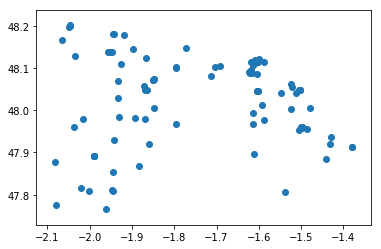

In [96]:
gdf.plot() 

In [97]:
m = folium.Map()
for i in range(gdf.shape[0]):
    folium.CircleMarker(location=[gdf.iloc[i,1], gdf.iloc[i,2]  ], radius=2,color='darkblue',
        fill_color='darkblue').add_to(m)
m

In [92]:
gdf.shape

(100, 5)